# Neural networks with PyTorch

<hr style="clear:both">

This notebook is part of a series of exercises for the CIVIL-226 Introduction to Machine Learning for Engineers course at EPFL and adapted for the ME-390. Copyright (c) 2021 [VITA](https://www.epfl.ch/labs/vita/) lab at EPFL  
Use of this source code is governed by an MIT-style license that can be found in the LICENSE file or at https://www.opensource.org/licenses/MIT

**Author(s):** David Mizrahi
<hr style="clear:both">


In this exercise, we'll cover the basics of the [PyTorch](https://pytorch.org) package and use it to implement a simple neural network.

## Installation

In [2]:
# Verify that PyTorch and torchvision are installed correctly
# Note: You may need to restart your kernel and re-run this cell before running the following cells

import torch
import torchvision
import torchsummary

/home/alan/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.__version__

'1.13.0+cu117'

In [4]:
torchvision.__version__

'0.14.0+cu117'

#### For Google Colab
You can run this notebook in Google Colab using the following link: https://colab.research.google.com/github/SYCAMORE-Lab/ME-390-2022/blob/master/ME-390-Exercises/ME-390-06-neural-nets/neural_nets_pytorch.ipynb

In [5]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  # Clone the entire repo to access the files
  !git clone -l -s https://github.com/SYCAMORE-Lab/ME-390-2022.git cloned-repo
  %cd cloned-repo/ME-390-Exercises/ME-390-06-neural-nets/

# Exercise 1: Deep Learning with PyTorch

PyTorch's website offers a tutorial on the basics of PyTorch, which can be found  at the following link: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

We recommend completing this tutorial before moving on to the second exercise.

# Exercise 2: Simple neural nets with PyTorch

In this exercise, we'll implement classifiers with PyTorch.
More specifically, we'll compare a simple logistic regression model to a simple neural network on the MNIST dataset.

Here is the general pipeline used to train neural networks with PyTorch:

```
1. Load the dataset
2. Initialize a dataloader, define data transforms
3. Define and instantiate network architecture
4. Choose a loss function
5. Choose an optimizer
6. Define the training loop & number of epochs
7. Train the model
8. Check validation accuracy, visualize results, adjust hyper-parameters (not done in this exercise)
9. Repeat steps 2-9 until satisfied with validation accuracy (not done in this exercise)
10. Check test accuracy
```

*Recall, Epoch: number of times that the learning algorithm will work through the entire training set*

In this exercise, we'll follow these steps to implement our classifiers. Let's get started!

## 1. Imports

In [6]:
# PyTorch & torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST

# Progress bar
from tqdm.auto import tqdm

# Helper files
import helpers
import metrics

Here is a brief description of these imported packages:

**PyTorch:**
- `torch.nn` Contains the basic building blocks to implement neural nets (incl. different types of layers and loss functions) | [Documentation](https://pytorch.org/docs/stable/nn.html)
- `torch.nn.functional` A functional (stateless) approach to torch.nn, often used for stateless objects (e.g. ReLU) | [Documentation](https://pytorch.org/docs/stable/nn.functional.html) | [More info](https://discuss.pytorch.org/t/what-is-the-difference-between-torch-nn-and-torch-nn-functional/33597/2)
- `torch.optim` A package implementing various optimization algorithms, such as SGD and Adam | [Documentation](https://pytorch.org/docs/stable/optim.html)

**torchvision:**
- `torchvision.transforms` Common image transformations
- `torchvision.datasets` Popular image datasets

**`tqdm`:** Popular package used to show progress bars | [Documentation](https://tqdm.github.io/)

**`helpers`**: Contains functions to help visualize data and predictions

**`metrics`:** Contains two simple classes that help keep track and compute the loss and accuracy over a training epoch

## 2. Loading and visualizing the data

### 2.1. Dataset

Here, we will use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, which consists of black-white images of hand-drawn digits. The training set has 60000 examples and the test set has 10000 examples. 
The `torchvision` package provides an easy way to load this data set. 


In [15]:
# Save dataset in a folder called "data"
root = "data"

# transforms.ToTensor() is used to convert the downloaded PIL Image to a torch Tensor
train_data = FashionMNIST(root, train=True, transform=transforms.ToTensor(), download=True)
test_data = FashionMNIST(root, train=False, transform=transforms.ToTensor(), download=True)

In [16]:
print(f"Images in training data: {len(train_data)}")
print(f"Images in test data: {len(test_data)}")

Images in training data: 60000
Images in test data: 10000


In [17]:
# Show the mapping from target value to class name (if you're using MNIST, you won't be too surprised)
{i: class_name for i, class_name in enumerate(train_data.classes)}

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

### 2.2. Dataloader

When training neural networks, we usually use mini-batches of data for each forward + backward pass. 

In order to obtain those mini-batches, we must pass our dataset through `torch.utils.DataLoader`, which combines the dataset and a sampler, and returns an iterable over the data and labels of our dataset.

In this exercise, we'll pick a batch size of 32.

In [18]:
batch_size = 32
# Reshuffle training data at every epoch, but not the test data 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

Let's take a look at one of our batches.

In [19]:
images, targets = iter(train_loader).next()

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

To understand how the images are represented, let us look at one of the images: 

In [12]:
print(images[0,0,:,:])

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0039, 0.0000,
         0.0000, 0.0000, 0.0000, 0.4392, 0.3137, 0.1373, 0.1569, 0.3373, 0.0353,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0157, 0.1373, 0.1647, 0.5882, 0.9804, 0.9451, 0.9020, 0.9020, 0.2627,
         0.1647, 0.0549, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1569, 0.2745,
         0.2784, 0.2784, 0.1922, 0.0431, 0.4667, 0.8824, 0.6588, 0.1255, 0.1529,
         0.3137, 0.2980, 0.3059, 0.1961, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2157, 0.2745, 0.1451,
         0.1333, 0.1451, 0.1333, 0.1451, 0.0353, 0.0000, 0.0000, 0.0941, 0.1529,
         0.1569, 0.1451, 0.1765, 0.2941, 0.3137, 0.0000

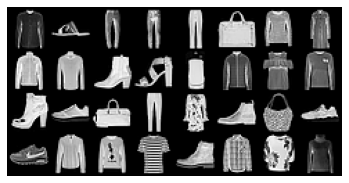

tensor([[6, 5, 1, 1, 1, 8, 2, 4],
        [4, 6, 9, 5, 0, 4, 6, 2],
        [9, 7, 8, 1, 3, 9, 8, 7],
        [7, 6, 2, 0, 9, 6, 6, 2]])


In [13]:
helpers.imshow(torchvision.utils.make_grid(images, nrow=8))
print(targets.reshape(-1, 8))

## 3. Simple model

First, we'll build a simple classifier (akin to logistic regression).

###  3.1 Network architecture

#### Short primer on `nn.Module`

In PyTorch, each neural net architecture is a subclass of `nn.Module` ([Documentation](https://pytorch.org/docs/stable/generated/torch.nn.Module.html))

To quote an [official tutorial](https://pytorch.org/tutorials/beginner/nlp/deep_learning_tutorial.html?highlight=module):

> All network components should inherit from `nn.Module` and override the `forward()` method. That is about it, as far as the boilerplate is concerned. Inheriting from `nn.Module` provides functionality to your component. For example, it makes it keep track of its trainable parameters, you can swap it between CPU and GPU with the `.to(device)` method, where device can be a CPU device `torch.device("cpu")` or CUDA device `torch.device("cuda:0")`.


In order to implement your model, you'll therefore need to fill in two methods:

**`__init__()`**: 

- Initialize your layers here, so that the module can keep track of these layers' parameters. 
- It is not necessary to initialize layers with no learnable parameters (e.g. `ReLU`), as you can use  the`nn.functional` API for those if you want.

**`forward()`**:

- Define your model architecture here (i.e. call your layers in the desired order). You can use any of the Tensor operations in the `forward` function.
- This function defines the computation performed at every call. The backward function (where gradients are computed) is automatically defined for you using autograd. 

The learnable parameters of a model are returned by `model.parameters()`.

#### One layer neural net

You should implement a one-layer network as follows:
- First, flatten the image so that rather than matrices they are seen as a vector of dimension 28x28=784.
- A fully-connected layer from the flattened input of shape (784,) to the output layer of shape (10,) as we have 10 different classes.

Note that there is no hidden layer here. 

Furthermore, the output layer provides a real value corresponding to each of the 10 classes for the digits 0, 1, 2, ..., 9. Hence, to use this network for classification, we can use a cross-entropy loss:: [`CrossEntropyLoss()` module](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Hence, we can obtain the probability of each of the 10 classes after training the network.

As a result, we also added a `predict()` method that adds this softmax layer, it'll be useful later on.

Notice that we use `class` from python to define the neural network. For a brief introduction to this, go back to Section 8 of the exercise 01-python.

**One layer neural net:**

<img src="https://github.com/SYCAMORE-Lab/ME-390-2022/blob/master/ME-390-Exercises/ME-390-06-neural-nets/images/1_layer_net.png?raw=1" width=220></img>

In [14]:
class OneLayerNet(nn.Module):
    """1-Layer MNIST classifier"""
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(784, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Flatten to get tensor of shape (batch_size, 784)
        x = x.flatten(start_dim=1)
        out = self.fc(x)
        return out

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """Predicts classes by calculating the softmax"""
        logits = self.forward(x)
        return F.softmax(logits, dim=1)

model = OneLayerNet()

**Question:** How many trainable parameters (weights) does this network have?

**Answer:**
YOUR ANSWER HERE

### 3.2. Loss function and optimizer

As mentioned, we choose Cross Entropy loss as our loss function. For training, we use Stochastic Gradient Descent (SGD) with a learning rate of 0.05 as our optimizer.

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

### 3.3. Training loop

The training loop can be defined as follows:

```
For each batch in the dataset:
   1. Load the batch
   2. Zero-out the accumulated gradients (PyTorch accumulates gradients during each iteration of an epoch. this is useful for some other neural network training tasks but not for our exercise).
   3. Run the forward pass through your model.
   4. Compute the loss.
   5. Run the backward pass, i.e. compute gradients of the loss w.r.t. to the weights.
   6. Update the weights using the optimizer.
```

Take a look at the `train()` function written for you below and predict how many iterations of the inner and outer for loops will be done by calling the train function on our dataset:

In [16]:
def train(model: torch.nn.Module, train_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, epochs: int):
    
    # Initialize metrics for loss and accuracy
    loss_metric = metrics.LossMetric()
    acc_metric = metrics.AccuracyMetric(k=1)
    
    # Sets the module in training mode (doesn't have any effect here, but good habit to take)
    model.train()
    
    for epoch in range(1, epochs + 1):
        
        # Progress bar set-up
        pbar = tqdm(total=len(train_loader), leave=True)
        pbar.set_description(f"Epoch {epoch}")
        
        # Iterate through data
        for data, target in train_loader:
            
            # Zero-out the gradients
            optimizer.zero_grad()
            
            # Forward pass
            out = model(data)
            
            # Compute loss
            loss = loss_fn(out, target)
            
            # Backward pass
            loss.backward()
            
            # Optimizer step
            optimizer.step()
            
            
            # Update metrics & progress bar
            loss_metric.update(loss.item(), data.shape[0])
            acc_metric.update(out, target)
            pbar.update()
            
        # End of epoch, show loss and acc
        pbar.set_postfix_str(f"Train loss: {loss_metric.compute():.3f} | Train acc: {acc_metric.compute() * 100:.2f}%")
        loss_metric.reset()
        acc_metric.reset()

Now that the train function is defined, it's time to actually train your model.

In [17]:
# Train model for 10 epochs
train(model, train_loader, loss_fn, optimizer, epochs=0)

**Question:** How many iterations are in each epoch? 

**Answer:** 
YOUR ANSWER HERE

### 3.4. Test accuracy

You should now have a model with > 90% train accuracy, but this doesn't tell the whole story. In order to actually estimate how good our model is, we need to check its accuracy on the test set.

Look through the function `test()` which computes the test accuracy of a given model on a specific dataset.

This function iterates through a dataset once (using a DataLoader) and displays the accuracy.

In [18]:
def test(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader):
    
    # Initialize accuracy metric
    acc_metric = metrics.AccuracyMetric(k=1)
    
    # Progress bar set-up
    pbar = tqdm(total=len(test_loader), leave=True)
    
    # Sets the module in eval mode (doesn't have any effect here, but good habit to take)
    model.eval()
    
    with torch.no_grad():
        
        # Iterate through data
        for data, target in dataloader:
            
            # Forward pass
            out = model(data)
            
            # Update accuracy metric
            acc_metric.update(out, target)

            # Update progress bar
            pbar.update()
            
    # End of epoch, show loss and acc
    test_acc = acc_metric.compute() * 100
    pbar.set_postfix_str(f"Acc: {test_acc:.2f}%")
    print(f"Accuracy is {test_acc:.2f}%")


In [19]:
test(model, test_loader)

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy is 6.60%


**Expected result:** >90% test accuracy on MNIST

We obtain an accuracy of over 90% with this simple softmax regression model. A random classifier would only get an accuracy of ~10% (why?), so this is quite an improvement!

But let's not stop there, we can do even better with just a few small changes. Let's see how!

## 4. Simple neural net (with hidden layers)

Time to implement (actual) neural networks. As you'll soon see, the entire pipeline is very similar, only the network architecture changes.

#### Network architecture

You should implement a three-layer fully-connected neural net (2 hidden layers) composed of the following:
- First, flatten the image (as done previously)
- A fully-connected layer from the flattened input of shape (784,) to the first hidden layer of shape (100, ), with ReLU as an activation.
- A fully-connected layer from the first hidden layer of shape (100,) to the second hidden layer of shape (100, ), with ReLU as an activation.
- A fully-connected layer from the second hidden layer of shape (100,) to the output layer of shape (10,).

Fully connected neural networks (FCNNs) are sometimes also referred to as multilayer perceptrons (MLP) in ML literature.

**Note:** You can use the OneLayerNet function above and simply fill in additional information for the layers below

**Three-layer neural net:**

<img src="https://github.com/SYCAMORE-Lab/ME-390-2022/blob/master/ME-390-Exercises/ME-390-06-neural-nets/images/3_layer_net.png?raw=1" width=250></img>

In [20]:
class ThreeLayerNet(nn.Module):
    """3-Layer neural net"""
    
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(784, 15)
        ### START CODE HERE ###
        ### Hint: you need two more linear layers here of appropriate dimension
        self.fc2 = nn.Linear(15, 15)
        self.fc3 = nn.Linear(15, 10)
        ### END CODE HERE ###

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Flatten to get tensor of shape (batch_size, 784)
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        ### START CODE HERE ###
        ### Hint: you need one more relu layer and the output layer     

        return out
        ### END CODE HERE ###

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """Predicts classes by calculating the softmax"""
        logits = self.forward(x)
        return F.softmax(logits, dim=1)

model = ThreeLayerNet()

**Question:** How many trainable parameters (weights) does this network have?

**Answer:**
YOUR ANSWER HERE

#### Loss & optimizer

Use the same loss function and optimizer as in the previous section. Namely, the Cross-Entropy loss and SGD with lr=0.05.

In [21]:
### START CODE HERE ###
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)
### END CODE HERE ###

#### Training

Use `train()` to launch the training process, use the same number of epochs as in the previous part.

In [22]:
### START CODE HERE ###
train(model, train_loader, loss_fn, optimizer, epochs=0)
### END CODE HERE ###

#### Test accuracy

Compute the test accuracy using `test()`.

In [23]:
### START CODE HERE ###
test(model, test_loader)
### END CODE HERE ###

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy is 10.00%


**Expected result:** >96% test accuracy on MNIST

## 5. Visualizing predictions

In [27]:
torchsummary.summary(model, (1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 15]          11,775
            Linear-2                   [-1, 15]             240
            Linear-3                   [-1, 10]             160
Total params: 12,175
Trainable params: 12,175
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


Let's take a look at a few of our model's predictions.

First, we'll get the predictions for one batch of our test data (this is where the `predict()` method becomes useful).

In [24]:
images, _ = iter(test_loader).next()
preds = model.predict(images)

Then, we'll use a function in `helpers` to view the classifier's softmax score next to each image.

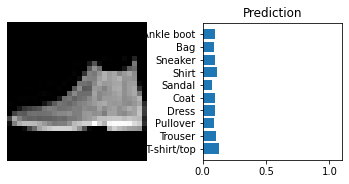

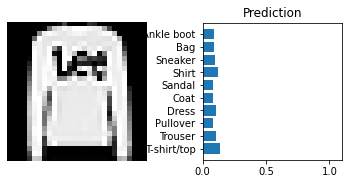

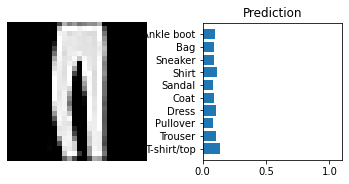

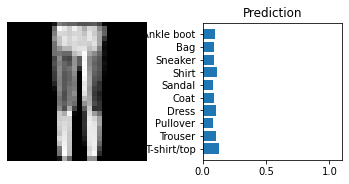

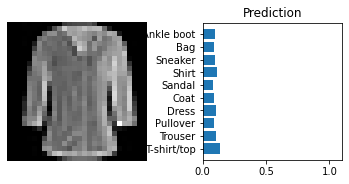

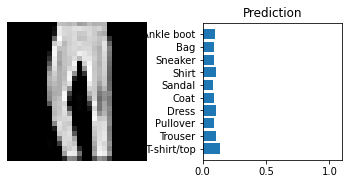

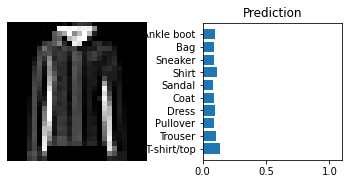

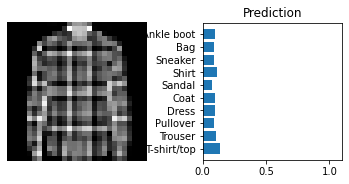

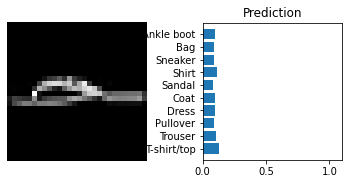

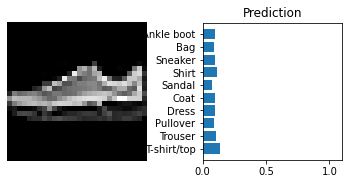

In [25]:
# Shows the image next to the classifier's softmax score
# Show for the first 10 images (change value to see more images)
for i in range(10):
    helpers.view_prediction(images[i], preds[i], test_data.classes)

Not bad, right?

Congratulations on finishing this exercise! If you want to try out your network on a different dataset, take a look at part 6.


## 6.  Training your model on a different dataset
There are many datasets designed to serve as a direct drop-in replacement to MNIST, one of them being [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist), by Zalando Research.

You can try out these two networks on Fashion-MNIST by just replacing the following two lines at the beginning of the notebook and re-running the entire code.

Replace:
```python
train_data = MNIST(root, train=True, transform=transforms.ToTensor(), download=True)
test_data = MNIST(root, train=False, transform=transforms.ToTensor(), download=True)
```

with:
```python
train_data = FashionMNIST(root, train=True, transform=transforms.ToTensor(), download=True)
test_data = FashionMNIST(root, train=False, transform=transforms.ToTensor(), download=True)
```

**Note:** FashionMNIST is a harder dataset than MNIST, so your accuracy will likely be lower.

## (Optional) Additional PyTorch resources
- PyTorch cheat sheet: https://pytorch.org/tutorials/beginner/ptcheat.html
- Other PyTorch tutorials: https://pytorch.org/tutorials/index.html
- PyTorch recipes: https://pytorch.org/tutorials/recipes/recipes_index.html (bite-sized code examples on specific PyTorch features)
- PyTorch examples: https://github.com/pytorch/examples